# multitone sideband cooling for 9 ions!
2024-10-22/16/28960

0.0766831679958584
['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Optimal parameters: a = 1.0367362032404444, b = 0.06053145660907184, c = -0.04052560136522788, nbar = 3.8480628476520184
Optimal parameters with their standard errors:
a = 1.0367362032404444 ± 0.0245989358779017
b = 0.06053145660907184 ± 0.00012305852747354168
c = -0.04052560136522788 ± 0.013150427217505697
nbar = 3.8480628476520184 ± 0.45329207648551234


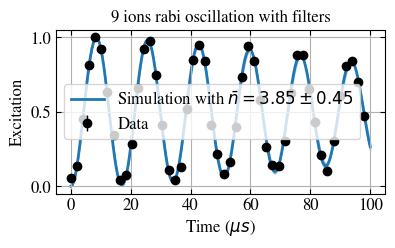

In [11]:
# Import necessary libraries for quantum physics calculations, optimization, numerical analysis, plotting, and file handling.
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

n_ion = 9
s = "scan_data"
kb = 1.38064852e-23
γ397 = 1 / 7e-9
ħ = 6.62607004e-34 / (2 * np.pi)
ω = 2 * np.pi * 0.177e6
η = 2 * np.pi * np.sqrt( ħ / (2 * ω * 6.6551079e-26)) / 729e-9 / np.sqrt(n_ion)
print(η)

def thermal_carrier(time, rabi, n̄, t0=0):
    A = 1
    res = [A/2 for t in time]
    N = 200
    for n in range(0, N):
        res -= A * (n̄ / (n̄ + 1))**n * np.cos(2 * np.pi * rabi * (1 - η**2 * n) * (time - t0)) / (2 * (n̄ + 1))
    return res

# data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240315/results/"
# date = "2024-03-15/"
# number = 8591
# file_path = data_path + date + f"23/00000{number}-RabiTimeScannThresholded_withOP.h5"
data_path = "C:/Users/bingr/OneDrive/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-22/"
number = 28942
file_path = data_path + date + f"15/0000{number}-RabiTimeScan.h5"
number = 29060
file_path = data_path + date + f"17/0000{number}-RabiTimeScan.h5"
number = 28960
file_path = data_path + date + f"16/0000{number}-RabiTimeScan.h5"
n_samples = 50
times = np.linspace(0, 100, 200) # Time array for simulation

# /Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240315/results/2024-03-15/23

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:-1]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:-1]

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))
intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
def fit_function(times, a, b, c, nbar):
    temp = 0
    for i in range(len(intensity_distribution)):
        temp += a * thermal_carrier(times, intensity_distribution[i] * b, nbar) + c
    return temp / len(intensity_distribution)

# Define your fitting function parameters
initial_guess = [0.8809862132150643, 0.0622167267179297, 0.14595767082374253, 6]  # Example initial guesses for a, b, c, and nbar
# 0.8809862132150643, b = 0.0622167267179297, c = 0.14595767082374253, nbar = 6.076080795652779
# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, 1, b_opt, 0, nbar_opt - nbar_err)
fit_upper_bound = fit_function(times, 1, b_opt, 0, nbar_opt + nbar_err)

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
plt.plot(times, fit_function(times, 1, b_opt, 0, nbar_opt), lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / a_opt, yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
number_drop = 0
plt.errorbar(rabi_t[number_drop:], (pmt_counts_avg_thresholded[number_drop:] - c_opt) * (1/a_opt), yerr=errorbar[number_drop:], fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation with filters', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.05, 1.05)
pdf_filename = 'Rabi_9_ions_no_shuttling_no_delay.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

# multitone sideband cooling for 9 ions!
AWG, delay 150 us no shuttle

['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Length of rabi_t:  29
The max of pmt_counts_avg_thresholded:  283.12
The min of pmt_counts_avg_thresholded:  64.54


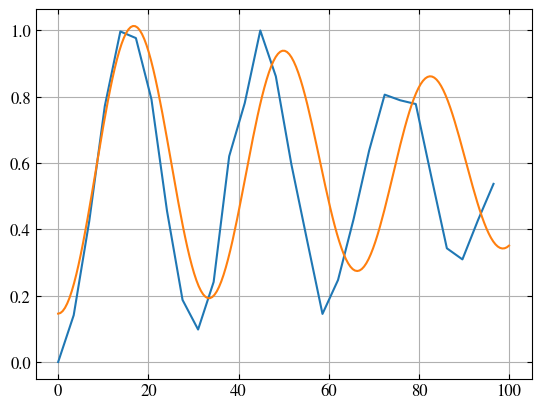

Optimal parameters: a = 1.0354065969448538, b = 0.03576434607044177, c = 0.03042504640414292, nbar = 13.686046985601967
Optimal parameters with their standard errors:
a = 1.0354065969448538 ± 0.0376763700760318
b = 0.03576434607044177 ± 0.0001466785009971459
c = 0.03042504640414292 ± 0.020164836399873702
nbar = 13.686046985601967 ± 1.2394237260438787


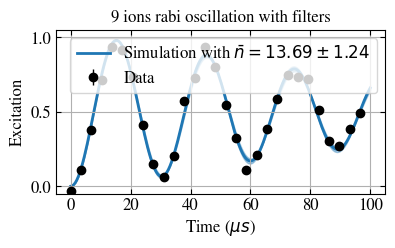

In [12]:
data_path = "C:/Users/bingr/OneDrive/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
number = 30376
file_path = data_path + date + f"18/0000{number}-RabiTimeScan.h5"
# number = 30400
# file_path = data_path + date + f"19/0000{number}-RabiTimeScan.h5"
n_samples = 50
times = np.linspace(0, 100, 200) # Time array for simulation

# /Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240315/results/2024-03-15/23

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:-1]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:-1]
    print("Length of rabi_t: ", len(rabi_t))

print("The max of pmt_counts_avg_thresholded: ", np.max(pmt_counts_avg_thresholded))
print("The min of pmt_counts_avg_thresholded: ", np.min(pmt_counts_avg_thresholded))

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))

# Define your fitting function parameters
initial_guess = [0.8809862132150643, 0.0322167267179297, 0.14595767082374253, 12]  # Example initial guesses for a, b, c, and nbar
# 0.8809862132150643, b = 0.0622167267179297, c = 0.14595767082374253, nbar = 12

plt.plot(rabi_t, pmt_counts_avg_thresholded)
plt.plot(times, fit_function(times, *initial_guess))
plt.show()

# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, 1, b_opt, 0, nbar_opt - nbar_err)
fit_upper_bound = fit_function(times, 1, b_opt, 0, nbar_opt + nbar_err)

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
plt.plot(times, fit_function(times, 1, b_opt, 0, nbar_opt), lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / a_opt, yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
number_drop = 0
plt.errorbar(rabi_t[number_drop:], (pmt_counts_avg_thresholded[number_drop:] - c_opt) * (1/a_opt), yerr=errorbar[number_drop:], fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation with filters', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.05, 1.05)
pdf_filename = 'Rabi_9_ions_no_shuttling_150us_delay.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

# multitone sideband cooling for 9 ions!
AWG, delay 170 us no shuttle

['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Length of rabi_t:  29
The max of pmt_counts_avg_thresholded:  278.12
The min of pmt_counts_avg_thresholded:  71.66


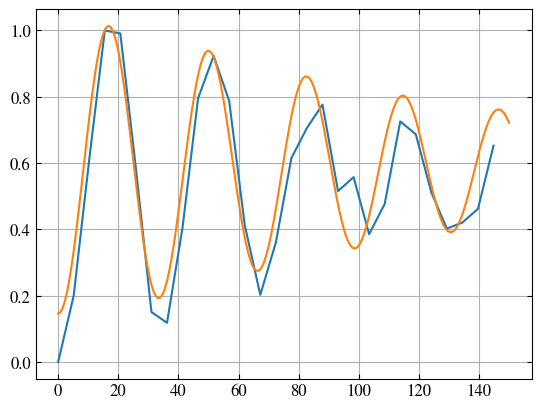

Optimal parameters: a = 1.1057732384033436, b = 0.03186782209984869, c = -0.009049584083265998, nbar = 19.490262930823747
Optimal parameters with their standard errors:
a = 1.1057732384033436 ± 0.06466074043255972
b = 0.03186782209984869 ± 0.00016577611603280312
c = -0.009049584083265998 ± 0.033634043499414124
nbar = 19.490262930823747 ± 2.1964970338091723


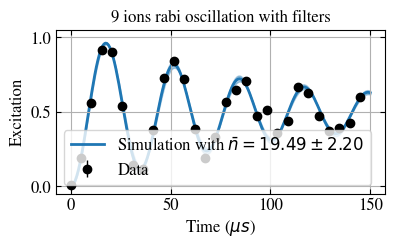

In [13]:
data_path = "C:/Users/bingr/OneDrive/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
# number = 30376
# file_path = data_path + date + f"18/0000{number}-RabiTimeScan.h5"
number = 30388
file_path = data_path + date + f"18/0000{number}-RabiTimeScan.h5"
n_samples = 50
times = np.linspace(0, 150, 200) # Time array for simulation

# /Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240315/results/2024-03-15/23

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:-1]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:-1]
    print("Length of rabi_t: ", len(rabi_t))

print("The max of pmt_counts_avg_thresholded: ", np.max(pmt_counts_avg_thresholded))
print("The min of pmt_counts_avg_thresholded: ", np.min(pmt_counts_avg_thresholded))

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))

# Define your fitting function parameters
initial_guess = [0.8809862132150643, 0.0322167267179297, 0.14595767082374253, 12]  # Example initial guesses for a, b, c, and nbar
# 0.8809862132150643, b = 0.0622167267179297, c = 0.14595767082374253, nbar = 12

plt.plot(rabi_t, pmt_counts_avg_thresholded)
plt.plot(times, fit_function(times, *initial_guess))
plt.show()

# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, 1, b_opt, 0, nbar_opt - nbar_err)
fit_upper_bound = fit_function(times, 1, b_opt, 0, nbar_opt + nbar_err)

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
plt.plot(times, fit_function(times, 1, b_opt, 0, nbar_opt), lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / a_opt, yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
number_drop = 0
plt.errorbar(rabi_t[number_drop:], (pmt_counts_avg_thresholded[number_drop:] - c_opt) * (1/a_opt), yerr=errorbar[number_drop:], fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation with filters', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.05, 1.05)
pdf_filename = 'Rabi_9_ions_no_shuttling_170us_delay.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

# multitone sideband cooling for 9 ions!
AWG, delay 200 us no shuttle

['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Length of rabi_t:  20
The max of pmt_counts_avg_thresholded:  279.8
The min of pmt_counts_avg_thresholded:  53.04


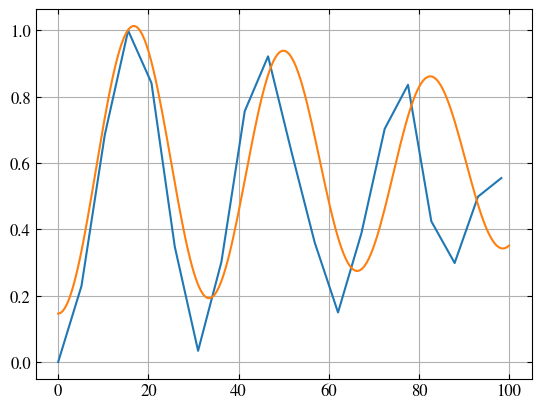

Optimal parameters: a = 1.109359335189838, b = 0.03568456871613771, c = -0.03552528270278651, nbar = 18.42155777633697
Optimal parameters with their standard errors:
a = 1.109359335189838 ± 0.08111392442770234
b = 0.03568456871613771 ± 0.000291077814760978
c = -0.03552528270278651 ± 0.04266541383145161
nbar = 18.42155777633697 ± 2.9040904611448344


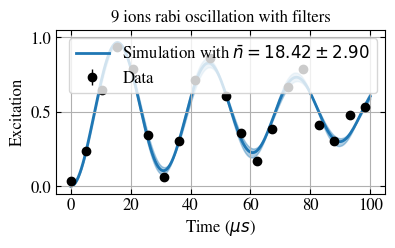

In [14]:
data_path = "C:/Users/bingr/OneDrive/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
# number = 30376
# file_path = data_path + date + f"18/0000{number}-RabiTimeScan.h5"
number = 30400
file_path = data_path + date + f"19/0000{number}-RabiTimeScan.h5"
n_samples = 50
times = np.linspace(0, 100, 200) # Time array for simulation

# /Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240315/results/2024-03-15/23

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:-10]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:-10]
    print("Length of rabi_t: ", len(rabi_t))

print("The max of pmt_counts_avg_thresholded: ", np.max(pmt_counts_avg_thresholded))
print("The min of pmt_counts_avg_thresholded: ", np.min(pmt_counts_avg_thresholded))

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))

# Define your fitting function parameters
initial_guess = [0.8809862132150643, 0.0322167267179297, 0.14595767082374253, 12]  # Example initial guesses for a, b, c, and nbar
# 0.8809862132150643, b = 0.0622167267179297, c = 0.14595767082374253, nbar = 12

plt.plot(rabi_t, pmt_counts_avg_thresholded)
plt.plot(times, fit_function(times, *initial_guess))
plt.show()

# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, 1, b_opt, 0, nbar_opt - nbar_err)
fit_upper_bound = fit_function(times, 1, b_opt, 0, nbar_opt + nbar_err)

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
plt.plot(times, fit_function(times, 1, b_opt, 0, nbar_opt), lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / a_opt, yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
number_drop = 0
plt.errorbar(rabi_t[number_drop:], (pmt_counts_avg_thresholded[number_drop:] - c_opt) * (1/a_opt), yerr=errorbar[number_drop:], fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation with filters', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.05, 1.05)
pdf_filename = 'Rabi_9_ions_no_shuttling_200us_delay.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

# multitone sideband cooling for 9 ions!
AWG, delay 250 us no shuttle

['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Length of rabi_t:  20
The max of pmt_counts_avg_thresholded:  280.58
The min of pmt_counts_avg_thresholded:  60.1


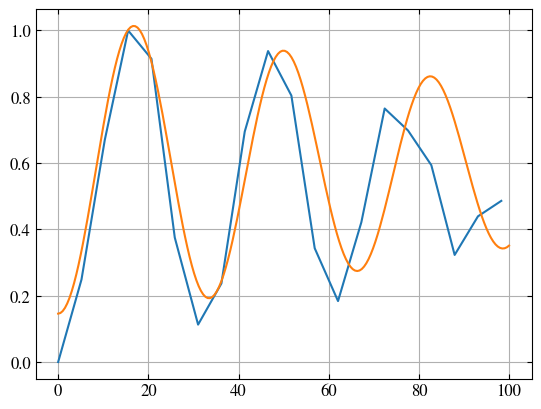

Optimal parameters: a = 1.1243379064128074, b = 0.03523099067584847, c = -0.02726720663122877, nbar = 19.727792606245938
Optimal parameters with their standard errors:
a = 1.1243379064128074 ± 0.07466107878389555
b = 0.03523099067584847 ± 0.0002627770789496673
c = -0.02726720663122877 ± 0.03907682642597555
nbar = 19.727792606245938 ± 2.735645184114445


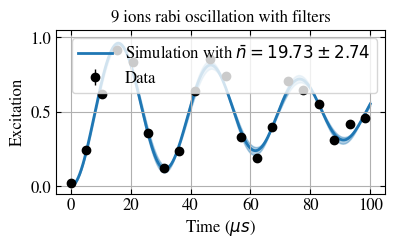

In [15]:
data_path = "C:/Users/bingr/OneDrive/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
# number = 30376
# file_path = data_path + date + f"18/0000{number}-RabiTimeScan.h5"
number = 30406
file_path = data_path + date + f"19/0000{number}-RabiTimeScan.h5"
n_samples = 50
times = np.linspace(0, 100, 200) # Time array for simulation

# /Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240315/results/2024-03-15/23

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:-10]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:-10]
    print("Length of rabi_t: ", len(rabi_t))

print("The max of pmt_counts_avg_thresholded: ", np.max(pmt_counts_avg_thresholded))
print("The min of pmt_counts_avg_thresholded: ", np.min(pmt_counts_avg_thresholded))

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))

# Define your fitting function parameters
initial_guess = [0.8809862132150643, 0.0322167267179297, 0.14595767082374253, 12]  # Example initial guesses for a, b, c, and nbar
# 0.8809862132150643, b = 0.0622167267179297, c = 0.14595767082374253, nbar = 12

plt.plot(rabi_t, pmt_counts_avg_thresholded)
plt.plot(times, fit_function(times, *initial_guess))
plt.show()

# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, 1, b_opt, 0, nbar_opt - nbar_err)
fit_upper_bound = fit_function(times, 1, b_opt, 0, nbar_opt + nbar_err)

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
plt.plot(times, fit_function(times, 1, b_opt, 0, nbar_opt), lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / a_opt, yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
number_drop = 0
plt.errorbar(rabi_t[number_drop:], (pmt_counts_avg_thresholded[number_drop:] - c_opt) * (1/a_opt), yerr=errorbar[number_drop:], fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation with filters', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.05, 1.05)
pdf_filename = 'Rabi_9_ions_no_shuttling_250us_delay.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

# multitone sideband cooling for 9 ions!
AWG, delay 300 us no shuttle

['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Length of rabi_t:  29
The max of pmt_counts_avg_thresholded:  271.48
The min of pmt_counts_avg_thresholded:  67.54


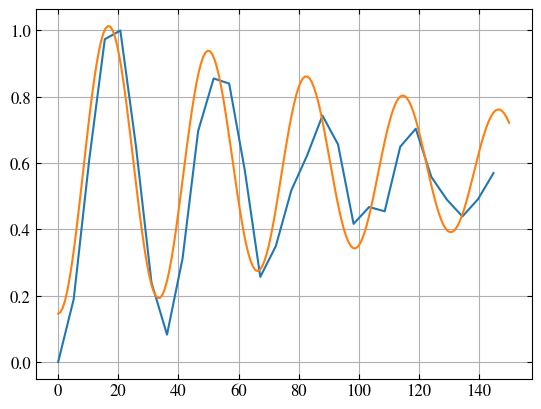

Optimal parameters: a = 1.1276685427311863, b = 0.03136764045733888, c = -0.018633167703095404, nbar = 23.731985790032926
Optimal parameters with their standard errors:
a = 1.1276685427311863 ± 0.055263961433241054
b = 0.03136764045733888 ± 0.00014217414793102616
c = -0.018633167703095404 ± 0.02844473147206043
nbar = 23.731985790032926 ± 2.127836436957442


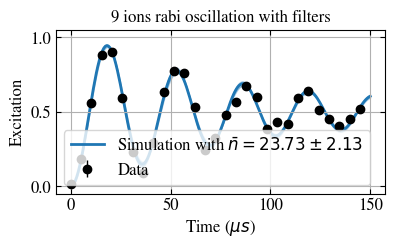

In [16]:
data_path = "C:/Users/bingr/OneDrive/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
# number = 30376
# file_path = data_path + date + f"18/0000{number}-RabiTimeScan.h5"
number = 30462
file_path = data_path + date + f"19/0000{number}-RabiTimeScan.h5"
n_samples = 50
times = np.linspace(0, 150, 200) # Time array for simulation

# /Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240315/results/2024-03-15/23

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:-1]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:-1]
    print("Length of rabi_t: ", len(rabi_t))

print("The max of pmt_counts_avg_thresholded: ", np.max(pmt_counts_avg_thresholded))
print("The min of pmt_counts_avg_thresholded: ", np.min(pmt_counts_avg_thresholded))

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))

# Define your fitting function parameters
initial_guess = [0.8809862132150643, 0.0322167267179297, 0.14595767082374253, 12]  # Example initial guesses for a, b, c, and nbar
# 0.8809862132150643, b = 0.0622167267179297, c = 0.14595767082374253, nbar = 12

plt.plot(rabi_t, pmt_counts_avg_thresholded)
plt.plot(times, fit_function(times, *initial_guess))
plt.show()

# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, 1, b_opt, 0, nbar_opt - nbar_err)
fit_upper_bound = fit_function(times, 1, b_opt, 0, nbar_opt + nbar_err)

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
plt.plot(times, fit_function(times, 1, b_opt, 0, nbar_opt), lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / a_opt, yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
number_drop = 0
plt.errorbar(rabi_t[number_drop:], (pmt_counts_avg_thresholded[number_drop:] - c_opt) * (1/a_opt), yerr=errorbar[number_drop:], fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation with filters', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.05, 1.05)
pdf_filename = 'Rabi_9_ions_no_shuttling_300us_delay.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

# multitone sideband cooling for 9 ions!
AWG, delay 1000 us no shuttle

['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']
Length of rabi_t:  39
The max of pmt_counts_avg_thresholded:  271.22
The min of pmt_counts_avg_thresholded:  85.2


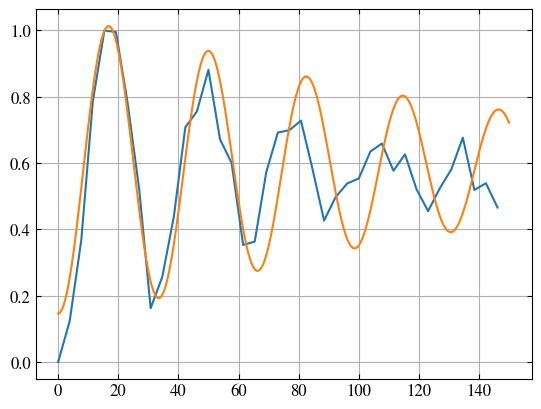

Optimal parameters: a = 1.213589393897323, b = 0.0351313552105114, c = -0.037525234473019885, nbar = 36.78938105189318
Optimal parameters with their standard errors:
a = 1.213589393897323 ± 0.07070765480844801
b = 0.0351313552105114 ± 0.0001996836114259806
c = -0.037525234473019885 ± 0.035120226694198106
nbar = 36.78938105189318 ± 3.585116484086097


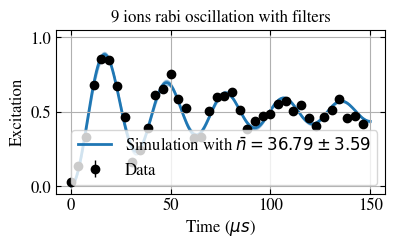

In [17]:
data_path = "C:/Users/bingr/OneDrive/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
# number = 30376
# file_path = data_path + date + f"18/0000{number}-RabiTimeScan.h5"
number = 30342
file_path = data_path + date + f"18/0000{number}-RabiTimeScan.h5"
n_samples = 50
times = np.linspace(0, 150, 200) # Time array for simulation

# /Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240315/results/2024-03-15/23

# Examine the structure within 'datasets'
with h5.File(file_path) as file:
    datasets_keys = list(file['datasets'].keys())
print(datasets_keys)

# Load the 'pmt_counts_avg_thresholded' and 'rabi_t' datasets for plotting
with h5.File(file_path, "r") as file:
    rabi_t = file['datasets']['rabi_t'][:-1]
    pmt_counts_avg_thresholded = file['datasets']['pmt_counts_avg_thresholded'][:-1]
    print("Length of rabi_t: ", len(rabi_t))

print("The max of pmt_counts_avg_thresholded: ", np.max(pmt_counts_avg_thresholded))
print("The min of pmt_counts_avg_thresholded: ", np.min(pmt_counts_avg_thresholded))

errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))

# Define your fitting function parameters
initial_guess = [0.8809862132150643, 0.0322167267179297, 0.14595767082374253, 12]  # Example initial guesses for a, b, c, and nbar
# 0.8809862132150643, b = 0.0622167267179297, c = 0.14595767082374253, nbar = 12

plt.plot(rabi_t, pmt_counts_avg_thresholded)
plt.plot(times, fit_function(times, *initial_guess))
plt.show()

# Perform the curve fitting
popt, pcov = curve_fit(fit_function, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess)
# Extract the optimal values of a, b, c, and nbar
a_opt, b_opt, c_opt, nbar_opt = popt
print(f"Optimal parameters: a = {a_opt}, b = {b_opt}, c = {c_opt}, nbar = {nbar_opt}")
# Calculate the standard error (square root of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
# Extract the standard errors
a_err, b_err, c_err, nbar_err = perr
# Print the optimal parameters and their standard errors
print(f"Optimal parameters with their standard errors:")
print(f"a = {a_opt} ± {a_err}")
print(f"b = {b_opt} ± {b_err}")
print(f"c = {c_opt} ± {c_err}")
print(f"nbar = {nbar_opt} ± {nbar_err}")
fit_lower_bound = fit_function(times, 1, b_opt, 0, nbar_opt - nbar_err)
fit_upper_bound = fit_function(times, 1, b_opt, 0, nbar_opt + nbar_err)

# Plotting the data and the fit
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
# plt.plot(times, fit_function(times, *popt) / np.max(fit_function(times, *popt)), label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / np.max(fit_function(times, *popt)), yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
# plt.plot(times, fit_function(times, *popt) / a_opt, lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f}$', zorder=1)
plt.plot(times, fit_function(times, 1, b_opt, 0, nbar_opt), lw=2, label=f'Simulation with $\\bar{{n}} = {nbar_opt:.2f} \\pm {nbar_err:.2f}$', zorder=1)
plt.fill_between(times, fit_lower_bound, fit_upper_bound, color='C0', alpha=0.2)    #, label='Uncertainty in $\\bar{n}$'
plt.fill_between(times, fit_upper_bound, fit_lower_bound, color='C0', alpha=0.2)
# plt.errorbar(rabi_t, pmt_counts_avg_thresholded / a_opt, yerr=errorbar, fmt='o', c='black', lw=1, zorder=2, label='Data')
number_drop = 0
plt.errorbar(rabi_t[number_drop:], (pmt_counts_avg_thresholded[number_drop:] - c_opt) * (1/a_opt), yerr=errorbar[number_drop:], fmt='o', c='black', lw=1, zorder=2, label='Data')
plt.title(r'9 ions rabi oscillation with filters', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
plt.grid(True)
plt.ylim(-0.05, 1.05)
pdf_filename = 'Rabi_9_ions_no_shuttling_1000us_delay.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

# Heating rate calculation

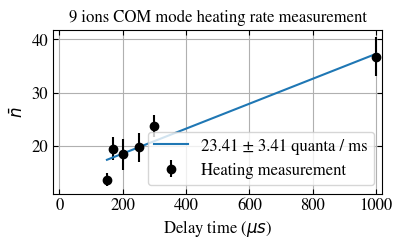

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Provided data
delay_time = np.array([0, 150, 170, 200, 250, 300, 1000])  # Delay times
nbar_list = np.array([3.85, 13.69, 19.49, 18.42, 19.73, 23.73, 36.79])  # Corresponding nbar values
nbar_errorbar = np.array([0.45, 1.24, 2.20, 2.90, 2.74, 2.13, 3.59])  # Error bars for nbar

delay_time = np.array([150, 170, 200, 250, 300, 1000])  # Delay times
nbar_list = np.array([13.69, 19.49, 18.42, 19.73, 23.73, 36.79])  # Corresponding nbar values
nbar_errorbar = np.array([1.24, 2.20, 2.90, 2.74, 2.13, 3.59])  # Error bars for nbar

# Perform linear fit with covariance matrix to get the errors of the fit parameters
fit_coefficients, cov_matrix = np.polyfit(delay_time, nbar_list, 1, cov=True)  # '1' for linear fit
fit_function = np.poly1d(fit_coefficients)
# Standard errors of the fit parameters
std_errors = np.sqrt(np.diag(cov_matrix))
slope_error = std_errors[0]
# Create a range of delay times for plotting the fit
fit_delay_time = np.linspace(min(delay_time), max(delay_time), 500)
fit_nbar = fit_function(fit_delay_time)
# Calculate the upper and lower bounds of the fit considering the error in the slope
fit_nbar_upper = np.poly1d([fit_coefficients[0] + slope_error, fit_coefficients[1]])(fit_delay_time)
fit_nbar_lower = np.poly1d([fit_coefficients[0] - slope_error, fit_coefficients[1]])(fit_delay_time)

# Provided data
delay_time_new = np.array([0, 300, 500])  # Delay times
nbar_list_new = np.array([28.65, 41.11, 51.22])  # Corresponding nbar values
nbar_errorbar_new = np.array([5.87, 4.65, 6.83])  # Error bars for nbar
# Perform linear fit with covariance matrix to get the errors of the fit parameters
fit_coefficients_new, cov_matrix_new = np.polyfit(delay_time_new, nbar_list_new, 1, cov=True)  # '1' for linear fit
fit_function_new = np.poly1d(fit_coefficients_new)
# Standard errors of the fit parameters
std_errors_new = np.sqrt(np.diag(cov_matrix_new))
slope_error_new = std_errors_new[0]
# Create a range of delay times for plotting the fit
fit_delay_time_new = np.linspace(min(delay_time_new), max(delay_time_new), 500)
fit_nbar_new = fit_function_new(fit_delay_time_new)
# Calculate the upper and lower bounds of the fit considering the error in the slope
fit_nbar_upper_new = np.poly1d([fit_coefficients[0] + slope_error, fit_coefficients[1]])(fit_delay_time_new)
fit_nbar_lower_new = np.poly1d([fit_coefficients[0] - slope_error, fit_coefficients[1]])(fit_delay_time_new)

# Plotting the data and the fit
plt.figure(figsize=(4.25, 4.25 / 2))
plt.errorbar(delay_time, nbar_list, yerr=nbar_errorbar, fmt='o', c='black', label='Heating measurement')
plt.plot(fit_delay_time, fit_nbar, '-', label=f'{fit_coefficients[0] * 1000:.2f} ± {slope_error * 1000:.2f} quanta / ms')
# plt.plot(fit_delay_time_new, fit_nbar_new, '-', label=f'{fit_coefficients_new[0] * 1000:.2f} ± {slope_error_new * 1000:.2f} quanta / ms')
# plt.fill_between(fit_delay_time, fit_nbar_lower, fit_nbar_upper, color='grey', alpha=0.2, label='Fit uncertainty')
plt.title(r'9 ions COM mode heating rate measurement', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Delay time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(f"$\\bar{{n}}$", fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlim(-20, 1020)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True)
plt.savefig('No_shuttling_heating_rate.pdf', format='pdf', bbox_inches='tight')
plt.show()